# B1, b2, b3 Comparison: 200 GeV Extended vs 26 GeV Extended

## Objective

Compare the main field **B1** (T), normal quadrupole **b2** (units), and normal
sextupole **b3** (units) at two operating points:

- **Injection before MD1** (~301 A, 26 GeV) — the MD1 injection plateau
- **Top of SFTPRO** (~4815 A, 400 GeV) — the SFTPRO flat-top

for two measurement campaigns on the same SPS MBB dipole:

| Dataset | Path | Description |
|---------|------|-------------|
| **200 GeV extended** | `01_200_extended` | Extended measurement, 200 GeV cycle |
| **26 GeV extended** | `03_26_extended` | Extended measurement, 26 GeV cycle |

Both datasets share the supercycle structure **LHC_pilot → MD1 → SFTPRO**,
repeated ~20 times, but were measured in **separate sessions** (~30 min apart)
with different MD1 flat-top currents.

### Key Analysis Questions

1. **Injection**: does B1 at the MD1 injection plateau differ between
   the two datasets?
2. **SFTPRO flat-top**: does B1 at the SFTPRO flat-top differ depending
   on whether the preceding MD1 was 200 GeV or 26 GeV?

Note: iron hysteresis has memory extending many cycles back, not just the
immediately preceding one.  The two datasets have different full
magnetisation histories (different sessions, different cycle types, different
pre-measurement states), so differences at **either** operating point may
reflect history-dependent effects.

### Settling Correction

At injection (~301 A), each supercycle's plateau has ~24 turns. The first
few turns are contaminated by **eddy-current settling** (τ ~ 0.5–5 s from
the eddy-current analysis). This notebook:

1. Groups injection turns by supercycle
2. Keeps only the **last N_LAST_TURNS_INJ** turns per supercycle (settled turns)
3. Removes outliers via MAD-based sigma clipping on B1

`FLIP_FIELD_SIGN` flips the sign of all Tesla columns when set to `True`.

---
## 1. Configuration

In [1]:
# =====================================================================
#  USER-SELECTABLE PARAMETERS  --  edit this section before running
# =====================================================================

# --- 200 GeV Extended ---
SESSION_200 = "2026_02_06/01_200_extended/20260206_144537_SPS_MBB"
SUBDIR_200  = "20260206_144559_MBB"

# --- 26 GeV Extended ---
SESSION_26 = "2026_02_06/03_26_extended/20260206_151808_SPS_MBB"
SUBDIR_26  = "20260206_151827_MBB"

# --- Common ---
SEGMENT = "NCS"
KN_CROSS_SESSION = "20251212_171026_SPS_MBA/CRMMMMH_AV-00000001/Kn_values_Seg_Main_A_AC.txt"
MAGNET_ORDER = 1          # dipole
R_REF = 0.02              # reference radius [m]
SAMPLES_PER_TURN = 1024   # encoder samples per revolution
OPTIONS = ("dri", "rot", "cel", "fed")
PLATEAU_I_RANGE_MAX = 2.5 # A -- plateau detection threshold
MIN_B1_T = 1e-4           # minimum main field for normalization

# --- Settling & selection ---
N_LAST_TURNS_INJ = 18     # keep last 18 of ~24 injection turns per supercycle
                           # (skip first ~6 turns for eddy-current settling)
N_LAST_TURNS_HIGH = None   # use all flat-high turns (no settling concern at SFTPRO top)

# --- Outlier removal ---
N_SIGMA_CLIP = 5           # remove turns where |B1 - median| > N * MAD_sigma
                           # (catches ramp-boundary turns that pass plateau threshold
                           #  but have current already changing within the turn)

# --- Sign convention ---
FLIP_FIELD_SIGN = False    # True = flip sign of all Tesla columns

print("B1 / b2 / b3 Comparison: 200 GeV vs 26 GeV Extended")
print("=" * 55)
print(f"  200 GeV : {SESSION_200}")
print(f"  26 GeV  : {SESSION_26}")
print(f"  Segment : {SEGMENT}")
print(f"  Plateau : I range < {PLATEAU_I_RANGE_MAX} A")
print(f"  N_LAST_TURNS_INJ  = {N_LAST_TURNS_INJ}")
print(f"  N_LAST_TURNS_HIGH = {N_LAST_TURNS_HIGH}")
print(f"  N_SIGMA_CLIP      = {N_SIGMA_CLIP}")
print(f"  FLIP_FIELD_SIGN   = {FLIP_FIELD_SIGN}")

B1 / b2 / b3 Comparison: 200 GeV vs 26 GeV Extended
  200 GeV : 2026_02_06/01_200_extended/20260206_144537_SPS_MBB
  26 GeV  : 2026_02_06/03_26_extended/20260206_151808_SPS_MBB
  Segment : NCS
  Plateau : I range < 2.5 A
  N_LAST_TURNS_INJ  = 18
  N_LAST_TURNS_HIGH = None
  N_SIGMA_CLIP      = 5
  FLIP_FIELD_SIGN   = False


---
## 2. Imports

In [ ]:
import sys
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

%matplotlib widget
plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 100,
})

# Locate repo root
REPO_ROOT = Path(".").resolve()
while REPO_ROOT != REPO_ROOT.parent:
    if (REPO_ROOT / "pyproject.toml").exists() or (REPO_ROOT / ".git").exists():
        break
    REPO_ROOT = REPO_ROOT.parent

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from rotating_coil_analyzer.analysis.kn_pipeline import load_segment_kn_txt
from rotating_coil_analyzer.analysis.utility_functions import (
    compute_block_averaged_range,
    detect_plateau_turns,
    classify_current,
    find_contiguous_groups,
    process_kn_pipeline,
    build_harmonic_rows,
    mad_sigma_clip,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

KN_PATH = REPO_ROOT / "measurements" / KN_CROSS_SESSION
assert KN_PATH.exists(), f"Kn file not found: {KN_PATH}"
kn = load_segment_kn_txt(str(KN_PATH))
print(f"Kn loaded: {len(kn.orders)} harmonics from {KN_PATH.name}")
print("Imports ready.")

---
## 3. Helper: Load & Process One Dataset

Processes **all plateau turns** (injection + flat-high) through the Kn pipeline,
applies the sign convention, groups injection turns by supercycle, selects
the **last N_LAST_TURNS_INJ** turns per supercycle as "settled", and removes
outliers via **MAD-based sigma clipping** on B1 (ramp-boundary contamination).

Returns both the full DataFrame and the cleaned settled subset.

In [ ]:
Ns = SAMPLES_PER_TURN
m = MAGNET_ORDER
MAX_ZR = 0.01
N_BLOCKS = 10

FILE_PAT = re.compile(
    r"Run_(\d+)_I_([\d.]+)A_(N?CS)_raw_measurement_data\.txt$"
)

ANALYSIS_LABELS = {"injection", "flat-mid", "flat-high"}


def load_and_process(session, meas_subdir, dataset_label=""):
    """Load one measurement session, process through Kn pipeline, apply
    sign convention, group injection by supercycle, select settled turns,
    and remove outliers via MAD sigma clipping on B1."""
    session_dir = REPO_ROOT / "measurements" / session
    run_dir = session_dir / meas_subdir

    # Find NCS raw file
    ncs_files = []
    for f in sorted(run_dir.iterdir()):
        match = FILE_PAT.search(f.name)
        if match and match.group(3) == SEGMENT:
            ncs_files.append(f)
    assert ncs_files, f"No {SEGMENT} raw files found in {run_dir}"
    raw_file = ncs_files[0]
    print(f"\n{'='*60}")
    print(f"  Dataset: {dataset_label or session}")
    print(f"  Raw file: {raw_file.name}")

    # Load raw data
    raw = np.loadtxt(raw_file)
    n_turns = raw.shape[0] // Ns
    n_keep = n_turns * Ns
    print(f"  Shape: {raw.shape} -> {n_turns} turns")
    print(f"  Time span: {raw[-1,0] - raw[0,0]:.1f} s ({(raw[-1,0] - raw[0,0])/60:.1f} min)")

    # Reshape into (n_turns, Ns)
    t_all = raw[:n_keep, 0].reshape(n_turns, Ns)
    flux_abs_all = raw[:n_keep, 1].reshape(n_turns, Ns)
    flux_cmp_all = raw[:n_keep, 2].reshape(n_turns, Ns)
    I_all = raw[:n_keep, 3].reshape(n_turns, Ns)

    # Auto-detect channel swap
    I_mean_quick = I_all.mean(axis=1)
    best_turn = np.argmax(np.abs(I_mean_quick))
    r1 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 1])
    r2 = robust_range(raw[best_turn*Ns:(best_turn+1)*Ns, 2])
    swap = (r2 > r1)
    if swap:
        flux_abs_all = raw[:n_keep, 2].reshape(n_turns, Ns)
        flux_cmp_all = raw[:n_keep, 1].reshape(n_turns, Ns)
        print("  (flux columns swapped)")

    # Per-turn statistics
    I_mean = I_all.mean(axis=1)
    t_mean = t_all.mean(axis=1)
    I_range, I_blocks = compute_block_averaged_range(I_all, Ns, N_BLOCKS)

    # Plateau detection
    plateau_info = detect_plateau_turns(I_blocks, I_mean, I_range, PLATEAU_I_RANGE_MAX)
    is_plateau = plateau_info["is_plateau"]

    # Classify current levels
    turn_label = np.array(["ramp"] * n_turns, dtype=object)
    for i in range(n_turns):
        if is_plateau[i]:
            turn_label[i] = classify_current(I_mean[i])

    for lab in ["injection", "flat-mid", "flat-high"]:
        mask = turn_label == lab
        n = mask.sum()
        if n > 0:
            print(f"  {lab:12s}: {n:4d} turns, I = {I_mean[mask].mean():.1f} +/- {I_mean[mask].std():.1f} A")

    # Process all plateau turns through Kn pipeline
    is_analysis = np.array([l in ANALYSIS_LABELS for l in turn_label])
    plateau_indices = np.where(is_analysis)[0]
    print(f"  Processing {len(plateau_indices)} plateau turns...")

    if len(plateau_indices) == 0:
        print("  WARNING: no plateau turns found!")
        empty = pd.DataFrame()
        return empty, empty, [], t_mean, I_mean, turn_label, is_plateau

    idx = plateau_indices
    result, C_merged, C_units, ok_main = process_kn_pipeline(
        flux_abs_turns=flux_abs_all[idx],
        flux_cmp_turns=flux_cmp_all[idx],
        t_turns=t_all[idx],
        I_turns=I_all[idx],
        kn=kn,
        r_ref=R_REF,
        magnet_order=m,
        options=OPTIONS,
        min_b1_T=MIN_B1_T,
        max_zr=MAX_ZR,
    )

    extra = [
        {
            "global_turn": int(idx[t]),
            "label": str(turn_label[idx[t]]),
            "I_range_A": float(I_range[idx[t]]),
        }
        for t in range(len(idx))
    ]

    rows = build_harmonic_rows(result, C_merged, C_units, ok_main, m, extra)
    df = pd.DataFrame(rows)

    # ── Sign convention ───────────────────────────────────────────────
    if FLIP_FIELD_SIGN:
        t_cols = [c for c in df.columns if c.endswith("_T")]
        df[t_cols] *= -1
        print("  [Sign flip applied to Tesla columns]")

    # ── Group injection turns by supercycle ────────────────────────────
    inj_mask_global = (turn_label == "injection")
    sc_groups_inj = find_contiguous_groups(inj_mask_global, min_length=2)

    df["sc_idx"] = -1
    settled_idx = []

    for gi, (gs, ge) in enumerate(sc_groups_inj):
        group_globals = set(range(gs, ge + 1))
        gmask = df["global_turn"].isin(group_globals) & (df["label"] == "injection")
        df.loc[gmask, "sc_idx"] = gi
        group_rows = df.index[gmask]
        if N_LAST_TURNS_INJ is not None and len(group_rows) > N_LAST_TURNS_INJ:
            settled_idx.extend(group_rows[-N_LAST_TURNS_INJ:])
        else:
            settled_idx.extend(group_rows)

    # Flat-high: group and optionally trim
    fh_mask_global = (turn_label == "flat-high")
    sc_groups_fh = find_contiguous_groups(fh_mask_global, min_length=2)

    for gi, (gs, ge) in enumerate(sc_groups_fh):
        group_globals = set(range(gs, ge + 1))
        gmask = df["global_turn"].isin(group_globals) & (df["label"] == "flat-high")
        df.loc[gmask, "sc_idx"] = gi
        group_rows = df.index[gmask]
        if N_LAST_TURNS_HIGH is not None and len(group_rows) > N_LAST_TURNS_HIGH:
            settled_idx.extend(group_rows[-N_LAST_TURNS_HIGH:])
        else:
            settled_idx.extend(group_rows)

    df_settled = df.loc[sorted(settled_idx)].copy()

    # ── Outlier removal: MAD sigma clipping on B1 ─────────────────────
    n_before = len(df_settled)
    df_settled, clip_removed = mad_sigma_clip(
        df_settled, "B1_T", N_SIGMA_CLIP, label_col="label"
    )
    n_clipped = n_before - len(df_settled)
    if n_clipped > 0:
        print(f"  Sigma clip ({N_SIGMA_CLIP} MAD sigma): removed {n_clipped} turns "
              f"({clip_removed})")

    n_inj_all = len(df[df["label"] == "injection"])
    n_inj_set = len(df_settled[df_settled["label"] == "injection"])
    n_fh_all = len(df[df["label"] == "flat-high"])
    n_fh_set = len(df_settled[df_settled["label"] == "flat-high"])
    print(f"  Supercycles: {len(sc_groups_inj)} injection, {len(sc_groups_fh)} flat-high")
    print(f"  Final: injection {n_inj_all} -> {n_inj_set}, flat-high {n_fh_all} -> {n_fh_set}")

    for lab in ["injection", "flat-high"]:
        sub = df_settled[(df_settled["label"] == lab) & df_settled["ok_main"]]
        if len(sub) > 0:
            print(f"    {lab:12s}: B1 = {sub['B1_T'].mean():.6f} T, "
                  f"b3 = {sub['b3_units'].mean():+.3f} units")

    return df, df_settled, sc_groups_inj, t_mean, I_mean, turn_label, is_plateau

---
## 4. Load Both Datasets

In [4]:
df_200, dfs_200, sc_200, t_200, I_200, lbl_200, plat_200 = load_and_process(
    SESSION_200, SUBDIR_200, "200 GeV Extended (01_200_extended)"
)

df_26, dfs_26, sc_26, t_26, I_26, lbl_26, plat_26 = load_and_process(
    SESSION_26, SUBDIR_26, "26 GeV Extended (03_26_extended)"
)


  Dataset: 200 GeV Extended (01_200_extended)
  Raw file: 20260206_144559_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt


  Shape: (1086464, 5) -> 1061 turns
  Time span: 1061.0 s (17.7 min)
  injection   :  488 turns, I = 300.9 +/- 0.2 A
  flat-high   :   74 turns, I = 4814.5 +/- 1.8 A
  Processing 562 plateau turns...
  Supercycles: 20 injection, 20 flat-high
  Final: injection 488 -> 360, flat-high 74 -> 72
    injection   : B1 = 0.115634 T, b3 = +0.177 units
    flat-high   : B1 = 1.793681 T, b3 = +0.345 units

  Dataset: 26 GeV Extended (03_26_extended)
  Raw file: 20260206_151827_MBB_Run_00_I_100.00A_NCS_raw_measurement_data.txt


  Shape: (1089536, 5) -> 1064 turns
  Time span: 1064.0 s (17.7 min)
  injection   :  520 turns, I = 300.9 +/- 0.2 A
  flat-high   :   72 turns, I = 4814.5 +/- 1.8 A
  Processing 592 plateau turns...
  Sigma clip (5 MAD sigma): removed 3 turns ({'injection': np.int64(3)})
  Supercycles: 20 injection, 20 flat-high
  Final: injection 520 -> 357, flat-high 72 -> 69
    injection   : B1 = 0.115641 T, b3 = +0.198 units
    flat-high   : B1 = 1.793817 T, b3 = +0.355 units


---
## 5. Current Profile Overview

Side-by-side current profiles with plateau turns colour-coded.

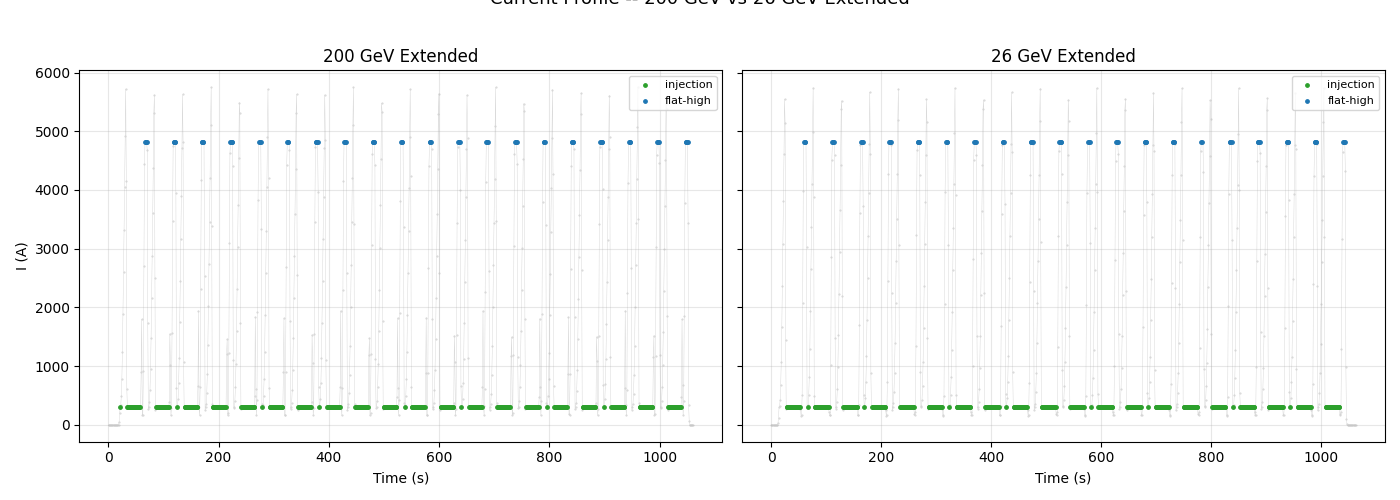

In [5]:
label_colors = {
    "injection": "tab:green",
    "flat-mid": "tab:purple",
    "flat-high": "tab:blue",
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, t_m, I_m, lbl, plat, title in [
    (axes[0], t_200, I_200, lbl_200, plat_200, "200 GeV Extended"),
    (axes[1], t_26, I_26, lbl_26, plat_26, "26 GeV Extended"),
]:
    ax.plot(t_m, I_m, ".-", markersize=1, linewidth=0.3,
            color="lightgrey", zorder=0)

    for lab, col in label_colors.items():
        mask = lbl == lab
        idx = np.where(mask)[0]
        if len(idx) > 0:
            ax.scatter(t_m[idx], I_m[idx], s=6, color=col,
                       zorder=2, label=lab)

    ax.set_xlabel("Time (s)")
    ax.set_title(title)
    ax.legend(fontsize=8, loc="upper right")

axes[0].set_ylabel("I (A)")
fig.suptitle("Current Profile -- 200 GeV vs 26 GeV Extended",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 6. Injection Plateau Grouping & Settling

Each injection plateau is split into supercycles (~24 turns each). The first
few turns show eddy-current settling. We select the **last N_LAST_TURNS_INJ**
turns per supercycle. The plot below shows delta B1 (relative to settled mean)
vs turn within supercycle, overlaying all supercycles.

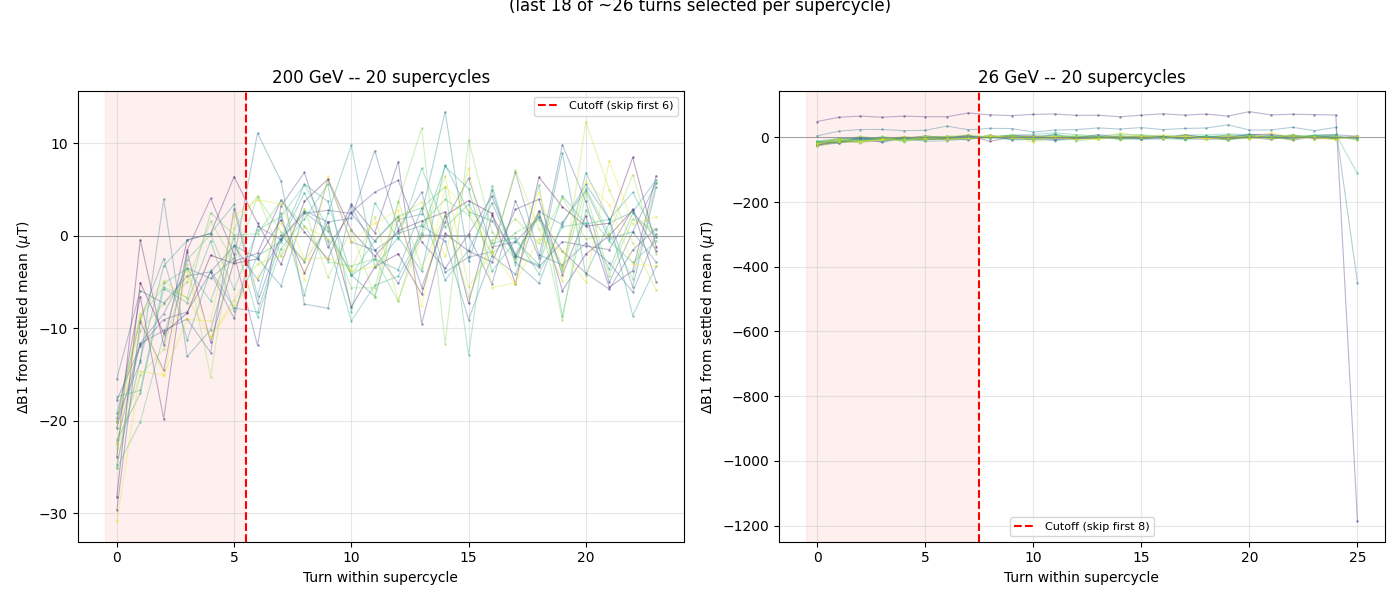

In [6]:
# Eddy-current settling at injection: B1 vs turn within supercycle
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, df_all, dfs, sc_grps, ds_name in [
    (axes[0], df_200, dfs_200, sc_200, "200 GeV"),
    (axes[1], df_26, dfs_26, sc_26, "26 GeV"),
]:
    inj = df_all[(df_all["label"] == "injection") & df_all["ok_main"]].copy()
    if len(inj) == 0:
        continue

    n_sc = inj["sc_idx"].max() + 1

    # Overlay all supercycles: delta from settled mean
    for sc in range(n_sc):
        sc_data = inj[inj["sc_idx"] == sc].sort_values("global_turn")
        if len(sc_data) < 2:
            continue
        turn_in_sc = np.arange(len(sc_data))
        # Subtract settled mean (last N turns) to show settling
        if N_LAST_TURNS_INJ is not None and len(sc_data) > N_LAST_TURNS_INJ:
            ref = sc_data["B1_T"].values[-N_LAST_TURNS_INJ:].mean()
        else:
            ref = sc_data["B1_T"].mean()
        delta = (sc_data["B1_T"].values - ref) * 1e6  # uT

        ax.plot(turn_in_sc, delta, ".-", markersize=2, alpha=0.35,
                color=plt.cm.viridis(sc / max(n_sc - 1, 1)), linewidth=0.8)

    # Mark cutoff line
    if N_LAST_TURNS_INJ is not None:
        typical_len = int(inj.groupby("sc_idx").size().median())
        cutoff = typical_len - N_LAST_TURNS_INJ
        if cutoff > 0:
            ax.axvline(cutoff - 0.5, color="red", linestyle="--",
                       linewidth=1.5, label=f"Cutoff (skip first {cutoff})")
            ax.axvspan(-0.5, cutoff - 0.5, color="red", alpha=0.06)

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Turn within supercycle")
    ax.set_ylabel("$\\Delta$B1 from settled mean ($\\mu$T)")
    ax.set_title(f"{ds_name} -- {n_sc} supercycles")
    ax.legend(fontsize=8)

fig.suptitle(
    f"Eddy-Current Settling at Injection\n"
    f"(last {N_LAST_TURNS_INJ} of ~{typical_len} turns selected per supercycle)",
    fontsize=12, y=1.04,
)
plt.tight_layout()
plt.show()

---
## 7. Transfer Function at Injection

TF = B1 / I at injection (settled turns only). Per-supercycle evolution
reveals history-dependent permeability changes.

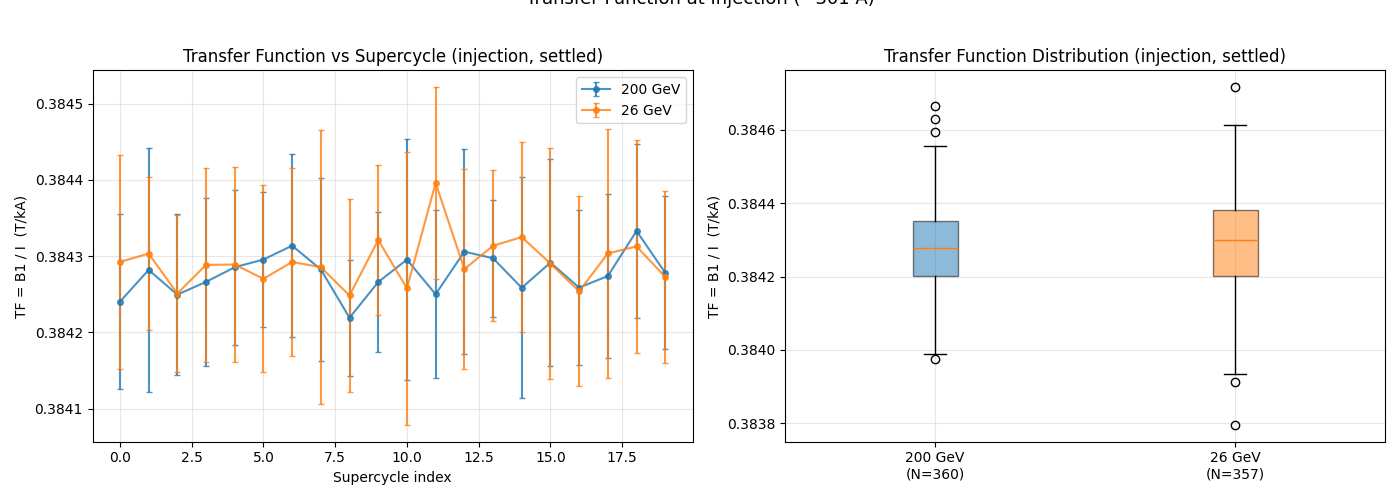

In [7]:
# Transfer function at injection: TF = B1 / I (T/kA)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: TF per supercycle
ax = axes[0]
for ds_name, dfs, col in [("200 GeV", dfs_200, "tab:blue"),
                           ("26 GeV", dfs_26, "tab:orange")]:
    inj = dfs[(dfs["label"] == "injection") & dfs["ok_main"]].copy()
    if len(inj) == 0:
        continue
    inj["TF_TperkA"] = inj["B1_T"] / (inj["I_mean_A"] / 1000.0)
    sc_tf = inj.groupby("sc_idx")["TF_TperkA"].agg(["mean", "std"]).reset_index()
    ax.errorbar(sc_tf["sc_idx"], sc_tf["mean"], yerr=sc_tf["std"],
                fmt="o-", markersize=4, capsize=2, color=col, alpha=0.8,
                label=ds_name)

ax.set_xlabel("Supercycle index")
ax.set_ylabel("TF = B1 / I  (T/kA)")
ax.set_title("Transfer Function vs Supercycle (injection, settled)")
ax.legend()

# Right: Box comparison
ax = axes[1]
box_data, box_labels, box_colors = [], [], []
for ds_name, dfs, col in [("200 GeV", dfs_200, "tab:blue"),
                           ("26 GeV", dfs_26, "tab:orange")]:
    inj = dfs[(dfs["label"] == "injection") & dfs["ok_main"]].copy()
    if len(inj) == 0:
        continue
    tf = (inj["B1_T"] / (inj["I_mean_A"] / 1000.0)).values
    box_data.append(tf)
    box_labels.append(f"{ds_name}\n(N={len(tf)})")
    box_colors.append(col)

if box_data:
    bp = ax.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
    for patch, c in zip(bp["boxes"], box_colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.5)

ax.set_ylabel("TF = B1 / I  (T/kA)")
ax.set_title("Transfer Function Distribution (injection, settled)")

fig.suptitle("Transfer Function at Injection (~301 A)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 8. Per-Supercycle Injection History

Mean B1, b2, b3 per supercycle at injection (settled turns only).
Reveals systematic drifts, history-dependent effects, and hysteresis differences.

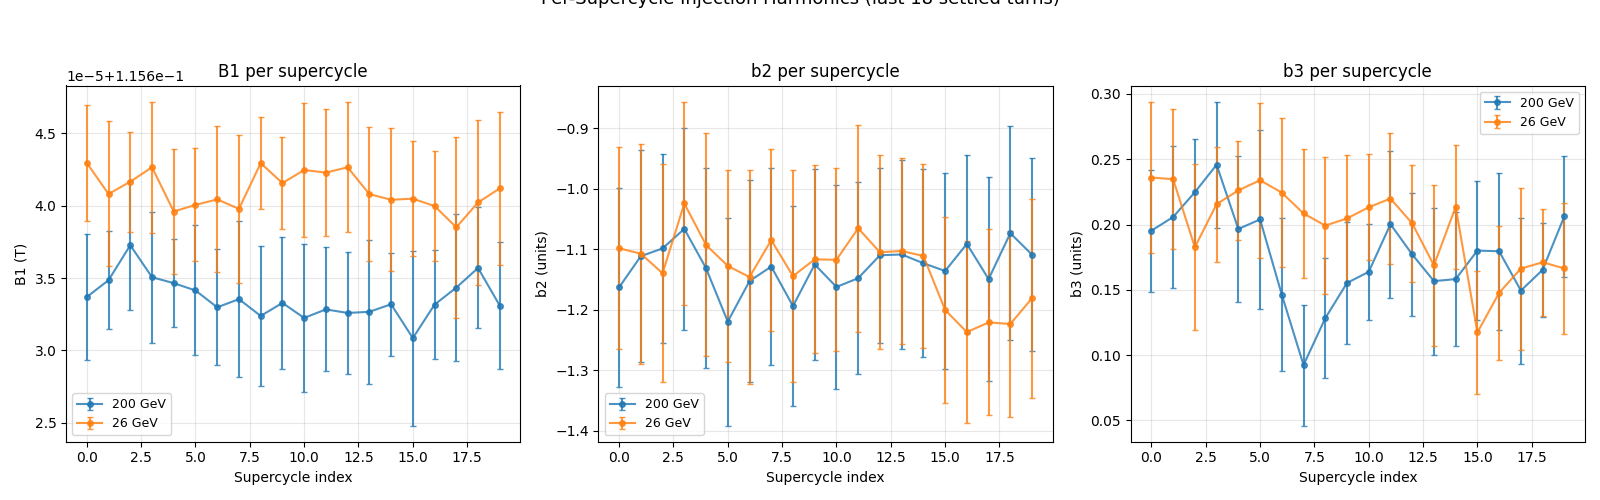

In [8]:
# Per-supercycle mean B1, b2, b3 at injection (settled turns only)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

harmonics = [("B1_T", "B1 (T)"), ("b2_units", "b2 (units)"), ("b3_units", "b3 (units)")]

for ax, (col_name, ylabel) in zip(axes, harmonics):
    for ds_name, dfs, col in [("200 GeV", dfs_200, "tab:blue"),
                               ("26 GeV", dfs_26, "tab:orange")]:
        inj = dfs[(dfs["label"] == "injection") & dfs["ok_main"]]
        if len(inj) == 0:
            continue
        sc_avg = inj.groupby("sc_idx")[col_name].agg(["mean", "std"]).reset_index()
        ax.errorbar(sc_avg["sc_idx"], sc_avg["mean"], yerr=sc_avg["std"],
                    fmt="o-", markersize=4, capsize=2, color=col, alpha=0.8,
                    label=ds_name)

    ax.set_xlabel("Supercycle index")
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=9)

axes[0].set_title("B1 per supercycle")
axes[1].set_title("b2 per supercycle")
axes[2].set_title("b3 per supercycle")

fig.suptitle(f"Per-Supercycle Injection Harmonics (last {N_LAST_TURNS_INJ} settled turns)",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 9. SFTPRO Flat-Top: Effect of Preceding MD1 Cycle

The SFTPRO flat-top (~4815 A) is preceded by different MD1 cycles in each dataset:
- **200 GeV dataset**: SFTPRO follows a 200 GeV MD1 (higher flat-top current)
- **26 GeV dataset**: SFTPRO follows a 26 GeV MD1 (lower flat-top current)

If the iron magnetisation history affects the field at SFTPRO, B1 and
harmonics should differ between the two datasets.  Note that the full
history differs too (separate sessions, different pre-measurement states),
so any observed difference is the combined effect of **all** history
differences, not just the immediately preceding MD1.

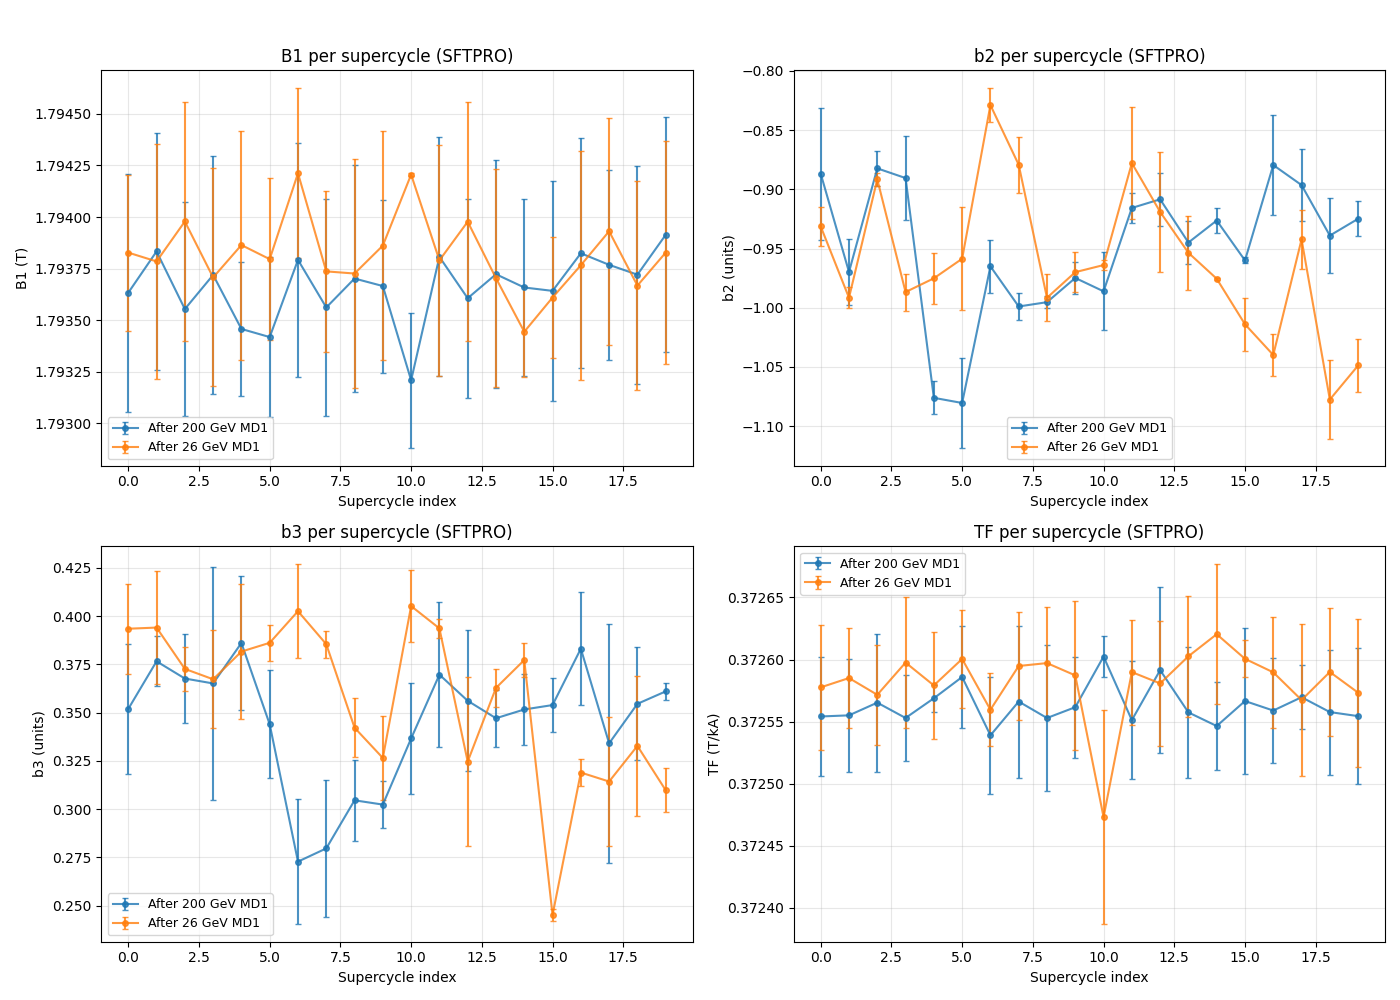


SFTPRO Flat-Top: Effect of Preceding MD1 Cycle
    Quantity       After 200 GeV MD1        After 26 GeV MD1           Delta   Signif.
------------------------------------------------------------------------------------------
      B1 (T)  +1.793681 +/- 0.000472  +1.793817 +/- 0.000462  -0.000136  1.7 sigma
  b2 (units)  -0.9445 +/- 0.0576  -0.9643 +/- 0.0636  +0.0198  1.9 sigma
  b3 (units)  +0.3447 +/- 0.0418  +0.3554 +/- 0.0418  -0.0107  1.5 sigma
   TF (T/kA)  +0.3726 +/- 0.0000  +0.3726 +/- 0.0000  -0.0000  2.8 sigma

N turns: 200 GeV = 72, 26 GeV = 69
The preceding MD1 cycle differs: 200 GeV flat-top vs 26 GeV flat-top.
Any significant delta indicates history-dependent iron magnetisation.


In [9]:
# Per-supercycle SFTPRO: B1, b2, b3, TF
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

harmonics_sftpro = [
    ("B1_T", "B1 (T)"),
    ("b2_units", "b2 (units)"),
    ("b3_units", "b3 (units)"),
    ("TF_TperkA", "TF (T/kA)"),
]

for ax, (col_name, ylabel) in zip(axes.ravel(), harmonics_sftpro):
    for ds_name, dfs, col in [
        ("After 200 GeV MD1", dfs_200, "tab:blue"),
        ("After 26 GeV MD1", dfs_26, "tab:orange"),
    ]:
        fh = dfs[(dfs["label"] == "flat-high") & dfs["ok_main"]].copy()
        if len(fh) == 0:
            continue
        if col_name == "TF_TperkA":
            fh["TF_TperkA"] = fh["B1_T"] / (fh["I_mean_A"] / 1000.0)
        sc_avg = fh.groupby("sc_idx")[col_name].agg(["mean", "std"]).reset_index()
        ax.errorbar(sc_avg["sc_idx"], sc_avg["mean"], yerr=sc_avg["std"],
                    fmt="o-", markersize=4, capsize=2, color=col, alpha=0.8,
                    label=ds_name)

    ax.set_xlabel("Supercycle index")
    ax.set_ylabel(ylabel)
    ax.legend(fontsize=9)

axes[0, 0].set_title("B1 per supercycle (SFTPRO)")
axes[0, 1].set_title("b2 per supercycle (SFTPRO)")
axes[1, 0].set_title("b3 per supercycle (SFTPRO)")
axes[1, 1].set_title("TF per supercycle (SFTPRO)")

fig.suptitle("SFTPRO Flat-Top (~4815 A): After 200 GeV MD1 vs After 26 GeV MD1",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Statistical summary
print("\nSFTPRO Flat-Top: Effect of Preceding MD1 Cycle")
print("=" * 90)
print(f"{'Quantity':>12s}  {'After 200 GeV MD1':>22s}  {'After 26 GeV MD1':>22s}  "
      f"{'Delta':>14s}  {'Signif.':>8s}")
print("-" * 90)

quantities = [
    ("B1_T", "B1 (T)", None),
    ("b2_units", "b2 (units)", None),
    ("b3_units", "b3 (units)", None),
    ("TF", "TF (T/kA)", "compute"),
]

for col_name, label, special in quantities:
    s200 = dfs_200[(dfs_200["label"] == "flat-high") & dfs_200["ok_main"]].copy()
    s26 = dfs_26[(dfs_26["label"] == "flat-high") & dfs_26["ok_main"]].copy()
    if len(s200) == 0 or len(s26) == 0:
        continue
    if special == "compute":
        v200 = s200["B1_T"] / (s200["I_mean_A"] / 1000.0)
        v26 = s26["B1_T"] / (s26["I_mean_A"] / 1000.0)
    else:
        v200 = s200[col_name]
        v26 = s26[col_name]

    m200, std200 = v200.mean(), v200.std()
    m26, std26 = v26.mean(), v26.std()
    diff = m200 - m26
    err = np.sqrt((std200**2 / len(v200)) + (std26**2 / len(v26)))
    sig = abs(diff) / err if err > 0 else 0

    if "T" in label and "units" not in label and "kA" not in label:
        print(f"{label:>12s}  {m200:+.6f} +/- {std200:.6f}  "
              f"{m26:+.6f} +/- {std26:.6f}  {diff:+.6f}  {sig:.1f} sigma")
    else:
        print(f"{label:>12s}  {m200:+.4f} +/- {std200:.4f}  "
              f"{m26:+.4f} +/- {std26:.4f}  {diff:+.4f}  {sig:.1f} sigma")

print(f"\nN turns: 200 GeV = {len(s200)}, 26 GeV = {len(s26)}")
print(f"The preceding MD1 cycle differs: 200 GeV flat-top vs 26 GeV flat-top.")
print("Any significant delta indicates history-dependent iron magnetisation.")

---
## 10. Summary Statistics Table (Settled Turns)

Mean +/- std of B1, b2, b3, and TF at each operating point for both datasets.
Injection uses **only settled turns** (last N_LAST_TURNS_INJ per supercycle).

In [10]:
# Build summary table using settled data
summary_rows = []

for ds_name, dfs in [("200 GeV", dfs_200), ("26 GeV", dfs_26)]:
    for lab, desc in [("injection", "Injection (MD1)"),
                      ("flat-high", "Top of SFTPRO")]:
        sub = dfs[(dfs["label"] == lab) & dfs["ok_main"]]
        if len(sub) == 0:
            continue
        tf = sub["B1_T"].mean() / (sub["I_mean_A"].mean() / 1000.0)
        summary_rows.append({
            "Dataset": ds_name,
            "Operating point": desc,
            "N turns": len(sub),
            "I mean (A)": f"{sub['I_mean_A'].mean():.1f}",
            "B1 mean (T)": f"{sub['B1_T'].mean():.6f}",
            "B1 std (T)": f"{sub['B1_T'].std():.6f}",
            "b2 mean (units)": f"{sub['b2_units'].mean():+.4f}",
            "b2 std (units)": f"{sub['b2_units'].std():.4f}",
            "b3 mean (units)": f"{sub['b3_units'].mean():+.4f}",
            "b3 std (units)": f"{sub['b3_units'].std():.4f}",
            "TF (T/kA)": f"{tf:.4f}",
        })

df_summary = pd.DataFrame(summary_rows)
print(f"[Settled data: last {N_LAST_TURNS_INJ} injection turns per supercycle]")
print()
print(df_summary.to_string(index=False))

[Settled data: last 18 injection turns per supercycle]

Dataset Operating point  N turns I mean (A) B1 mean (T) B1 std (T) b2 mean (units) b2 std (units) b3 mean (units) b3 std (units) TF (T/kA)
200 GeV Injection (MD1)      360      300.9    0.115634   0.000005         -1.1301         0.1628         +0.1766         0.0605    0.3843
200 GeV   Top of SFTPRO       72     4814.5    1.793681   0.000472         -0.9445         0.0576         +0.3447         0.0418    0.3726
 26 GeV Injection (MD1)      357      300.9    0.115641   0.000005         -1.1325         0.1684         +0.1976         0.0593    0.3843
 26 GeV   Top of SFTPRO       69     4814.5    1.793817   0.000462         -0.9643         0.0636         +0.3554         0.0418    0.3726


---
## 11. B1 Comparison: Injection vs SFTPRO Flat-Top

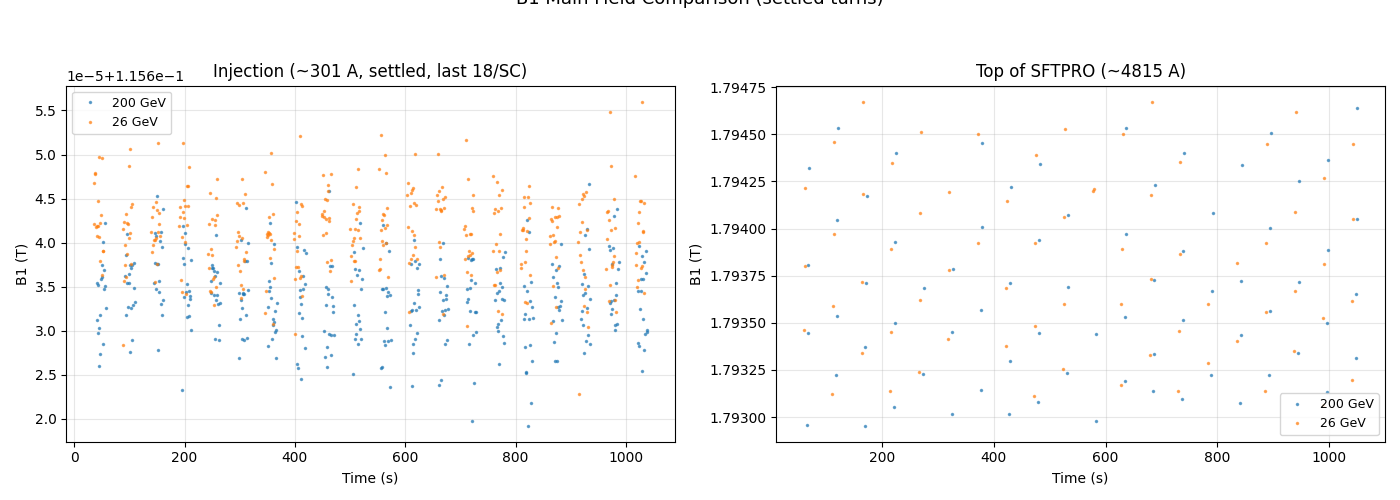

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, lab, title in [
    (axes[0], "injection", f"Injection (~301 A, settled, last {N_LAST_TURNS_INJ}/SC)"),
    (axes[1], "flat-high", "Top of SFTPRO (~4815 A)"),
]:
    for ds_name, dfs, col in [("200 GeV", dfs_200, "tab:blue"),
                               ("26 GeV", dfs_26, "tab:orange")]:
        sub = dfs[(dfs["label"] == lab) & dfs["ok_main"]]
        if len(sub) == 0:
            continue
        ax.plot(sub["time_s"].values, sub["B1_T"].values,
                ".", markersize=3, alpha=0.6, color=col, label=ds_name)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("B1 (T)")
    ax.set_title(title)
    ax.legend(fontsize=9)

fig.suptitle("B1 Main Field Comparison (settled turns)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 12. b2 Comparison: Injection vs SFTPRO Flat-Top

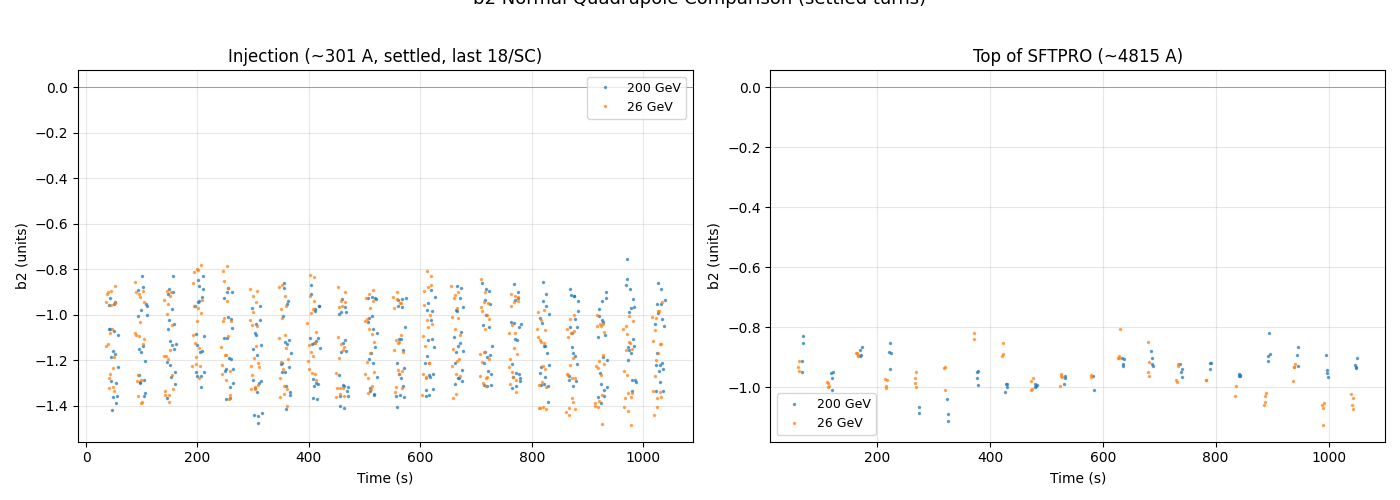

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, lab, title in [
    (axes[0], "injection", f"Injection (~301 A, settled, last {N_LAST_TURNS_INJ}/SC)"),
    (axes[1], "flat-high", "Top of SFTPRO (~4815 A)"),
]:
    for ds_name, dfs, col in [("200 GeV", dfs_200, "tab:blue"),
                               ("26 GeV", dfs_26, "tab:orange")]:
        sub = dfs[(dfs["label"] == lab) & dfs["ok_main"]]
        if len(sub) == 0:
            continue
        ax.plot(sub["time_s"].values, sub["b2_units"].values,
                ".", markersize=3, alpha=0.6, color=col, label=ds_name)

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b2 (units)")
    ax.set_title(title)
    ax.legend(fontsize=9)

fig.suptitle("b2 Normal Quadrupole Comparison (settled turns)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 13. b3 Comparison: Injection vs SFTPRO Flat-Top

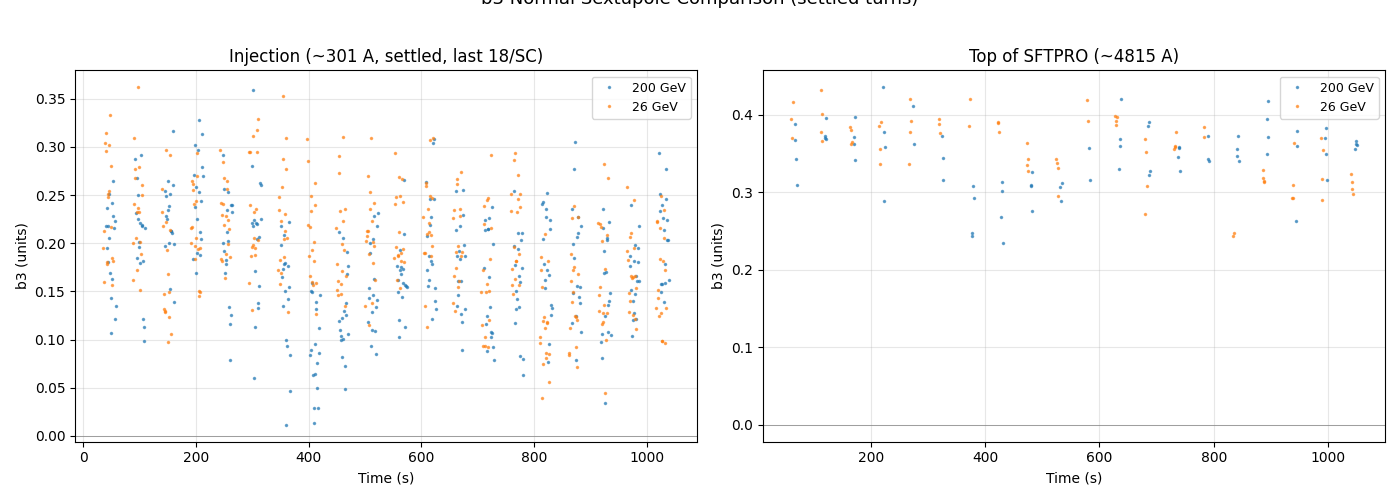

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, lab, title in [
    (axes[0], "injection", f"Injection (~301 A, settled, last {N_LAST_TURNS_INJ}/SC)"),
    (axes[1], "flat-high", "Top of SFTPRO (~4815 A)"),
]:
    for ds_name, dfs, col in [("200 GeV", dfs_200, "tab:blue"),
                               ("26 GeV", dfs_26, "tab:orange")]:
        sub = dfs[(dfs["label"] == lab) & dfs["ok_main"]]
        if len(sub) == 0:
            continue
        ax.plot(sub["time_s"].values, sub["b3_units"].values,
                ".", markersize=3, alpha=0.6, color=col, label=ds_name)

    ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("b3 (units)")
    ax.set_title(title)
    ax.legend(fontsize=9)

fig.suptitle("b3 Normal Sextupole Comparison (settled turns)", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 14. Box Plots: B1, b2, b3, TF by Dataset and Operating Point

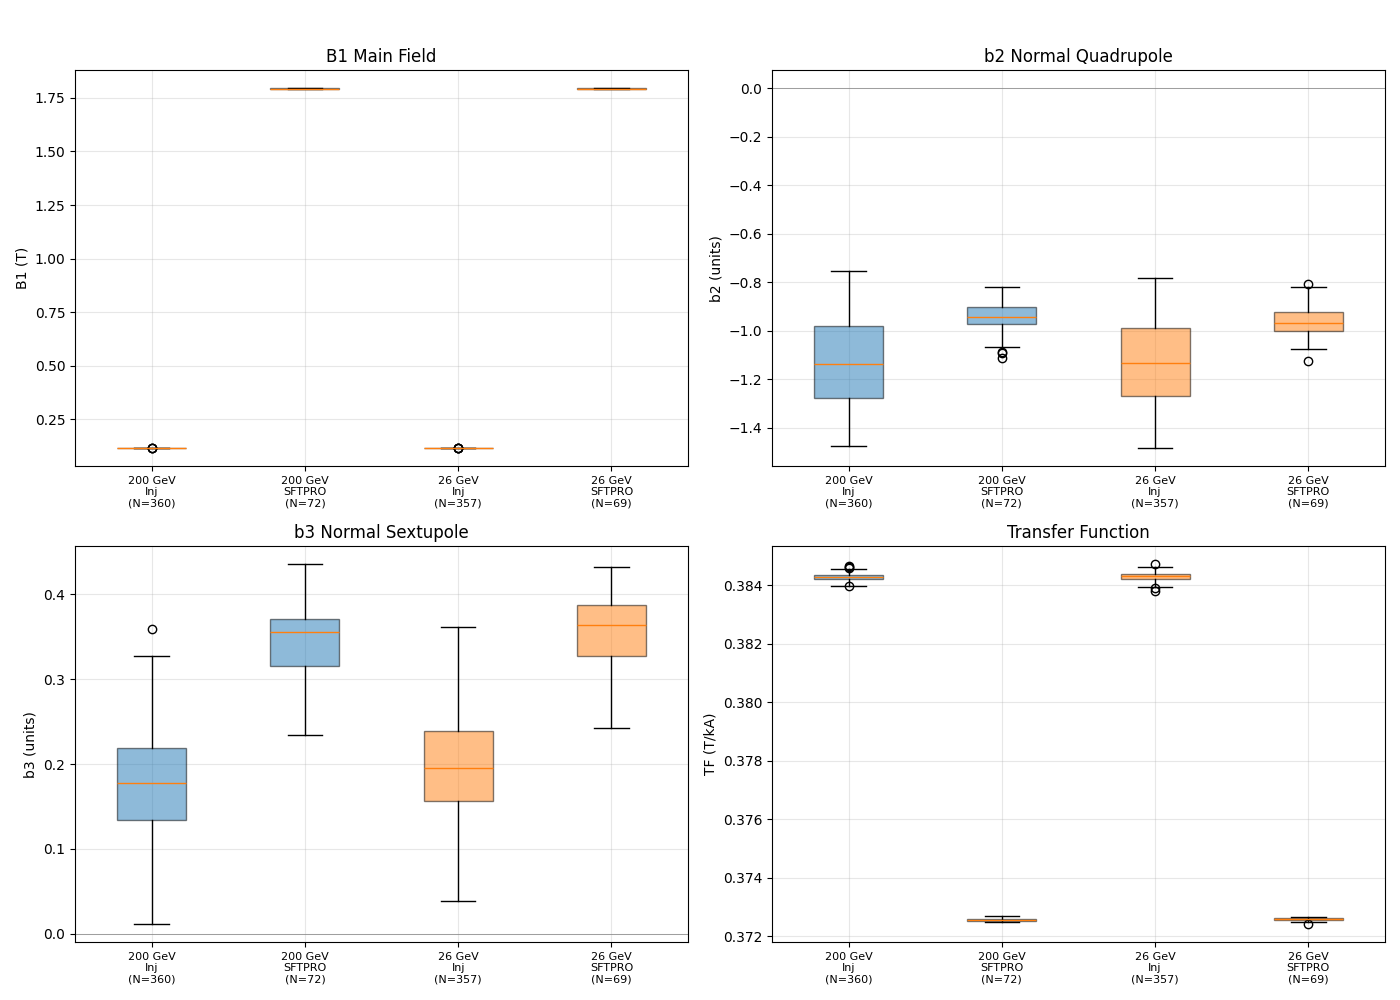

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

plot_specs = [
    ("B1_T", "B1 (T)", "B1 Main Field"),
    ("b2_units", "b2 (units)", "b2 Normal Quadrupole"),
    ("b3_units", "b3 (units)", "b3 Normal Sextupole"),
    ("TF_TperkA", "TF (T/kA)", "Transfer Function"),
]

for ax, (col_name, ylabel, title) in zip(axes, plot_specs):
    box_data = []
    box_labels = []
    box_colors = []

    for ds_name, dfs, base_col in [("200 GeV", dfs_200, "tab:blue"),
                                    ("26 GeV", dfs_26, "tab:orange")]:
        for lab, short in [("injection", "Inj"), ("flat-high", "SFTPRO")]:
            sub = dfs[(dfs["label"] == lab) & dfs["ok_main"]].copy()
            if len(sub) == 0:
                continue
            if col_name == "TF_TperkA":
                vals = (sub["B1_T"] / (sub["I_mean_A"] / 1000.0)).values
            else:
                vals = sub[col_name].values
            box_data.append(vals)
            box_labels.append(f"{ds_name}\n{short}\n(N={len(sub)})")
            box_colors.append(base_col)

    if box_data:
        bp = ax.boxplot(box_data, tick_labels=box_labels, patch_artist=True)
        for patch, col in zip(bp["boxes"], box_colors):
            patch.set_facecolor(col)
            patch.set_alpha(0.5)

    if col_name not in ("B1_T", "TF_TperkA"):
        ax.axhline(0, color="grey", linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis="x", labelsize=8)

fig.suptitle("Distribution Comparison: 200 GeV vs 26 GeV (settled turns)",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 15. Bar Chart: Mean Values with Error Bars

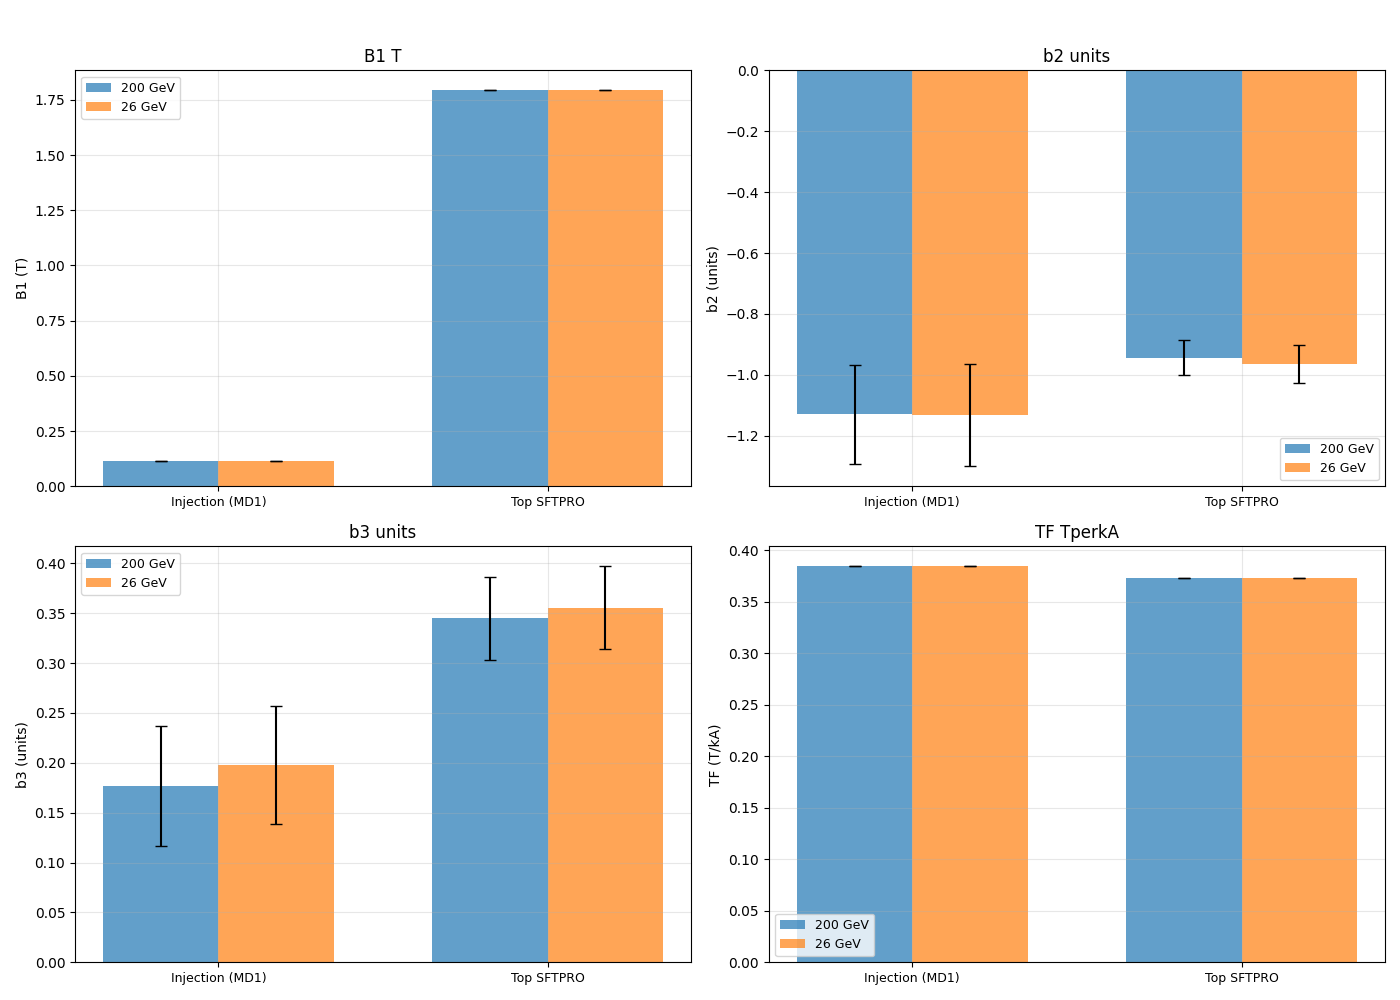

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

datasets = [("200 GeV", dfs_200), ("26 GeV", dfs_26)]
op_points = [("injection", "Injection (MD1)"), ("flat-high", "Top SFTPRO")]
colors_ds = {"200 GeV": "tab:blue", "26 GeV": "tab:orange"}
harmonics = [
    ("B1_T", "B1 (T)"),
    ("b2_units", "b2 (units)"),
    ("b3_units", "b3 (units)"),
    ("TF_TperkA", "TF (T/kA)"),
]

x = np.arange(len(op_points))
width = 0.35

for ax, (col_name, ylabel) in zip(axes, harmonics):
    for i, (ds_name, dfs) in enumerate(datasets):
        means = []
        stds = []
        for lab, _ in op_points:
            sub = dfs[(dfs["label"] == lab) & dfs["ok_main"]].copy()
            if len(sub) > 0:
                if col_name == "TF_TperkA":
                    vals = sub["B1_T"] / (sub["I_mean_A"] / 1000.0)
                else:
                    vals = sub[col_name]
                means.append(vals.mean())
                stds.append(vals.std())
            else:
                means.append(0)
                stds.append(0)

        offset = (i - 0.5) * width
        ax.bar(x + offset, means, width, yerr=stds, capsize=4,
               color=colors_ds[ds_name], alpha=0.7, label=ds_name)

    ax.set_xticks(x)
    ax.set_xticklabels([desc for _, desc in op_points], fontsize=9)
    ax.set_ylabel(ylabel)
    ax.set_title(col_name.replace("_", " "))
    ax.legend(fontsize=9)

fig.suptitle(f"Mean +/- Std: 200 GeV vs 26 GeV (settled, last {N_LAST_TURNS_INJ}/SC at inj.)",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 16. Statistical Significance: What Does "X Sigma" Mean?

When comparing two measurements (e.g. B1 from the 200 GeV dataset vs
the 26 GeV dataset), we want to answer: **is the observed difference
real, or could it just be measurement noise?**

We compute:

$$\text{sigma} = \frac{|\text{mean}_1 - \text{mean}_2|}{\sqrt{\dfrac{\text{std}_1^2}{N_1} + \dfrac{\text{std}_2^2}{N_2}}}$$

- **Numerator**: the absolute difference between the two dataset means.
- **Denominator**: the *standard error of that difference* — how precisely
  we know the difference, given the scatter (std) and number of turns (N)
  in each dataset.  More data and less scatter → smaller denominator →
  higher sigma.

### How to read the result

| Sigma | Interpretation | Chance the difference is just noise |
|:-----:|----------------|:-----------------------------------:|
| < 2 | No evidence of a real difference | > 5% |
| 2 – 3 | Suggestive — might be real, might be noise | 0.3% – 5% |
| **> 3** | **Strong evidence the difference is real** | **< 0.3%** |

### Important: high sigma ≠ large difference

Sigma tells you whether a difference is **reliably detected** (not noise).
It does **not** tell you whether the difference is **physically large or
operationally important**.

**Example from this data:**
- B1 at injection shows **~22 sigma** — but the actual difference is only
  **7 µT** (60 ppm of B1).  We average ~360 turns with only 5 µT scatter,
  so our uncertainty on each mean is ~0.3 µT.  Even a 7 µT shift stands
  out clearly against that tiny uncertainty.  *The difference is real but
  tiny.*
- TF at SFTPRO shows **2.8 sigma** — the difference is borderline (below
  the 3-sigma threshold), so it *probably* reflects a real effect but we
  cannot be fully confident.

### Takeaway

- **Sigma** answers: *"is there evidence of a real difference?"*
  (> 3 = yes, < 2 = no, 2–3 = maybe)
- **The actual values** (µT, units, mT/kA) answer: *"does it matter?"*

---
## 17. Difference Table (200 GeV – 26 GeV), Settled Turns

In [16]:
print(f"Difference: (200 GeV) - (26 GeV)  [settled, last {N_LAST_TURNS_INJ}/SC at injection]")
print("=" * 100)
print(f"{'Operating Point':>30s}  {'dB1 (T)':>12s}  {'db2 (units)':>14s}  "
      f"{'db3 (units)':>14s}  {'dTF (T/kA)':>14s}")
print("-" * 100)

results = []

for lab, desc in [("injection", "Injection (~301 A)"),
                  ("flat-high", "SFTPRO flat-top (~4815 A)")]:
    s200 = dfs_200[(dfs_200["label"] == lab) & dfs_200["ok_main"]]
    s26 = dfs_26[(dfs_26["label"] == lab) & dfs_26["ok_main"]]

    if len(s200) == 0 or len(s26) == 0:
        print(f"{desc:>30s}  {'N/A':>12s}  {'N/A':>14s}  {'N/A':>14s}  {'N/A':>14s}")
        continue

    dB1 = s200["B1_T"].mean() - s26["B1_T"].mean()
    db2 = s200["b2_units"].mean() - s26["b2_units"].mean()
    db3 = s200["b3_units"].mean() - s26["b3_units"].mean()

    tf200 = s200["B1_T"].mean() / (s200["I_mean_A"].mean() / 1000.0)
    tf26 = s26["B1_T"].mean() / (s26["I_mean_A"].mean() / 1000.0)
    dTF = tf200 - tf26

    # Propagated uncertainty (std of mean)
    dB1_err = np.sqrt((s200["B1_T"].std()**2 / len(s200)) +
                      (s26["B1_T"].std()**2 / len(s26)))
    db2_err = np.sqrt((s200["b2_units"].std()**2 / len(s200)) +
                      (s26["b2_units"].std()**2 / len(s26)))
    db3_err = np.sqrt((s200["b3_units"].std()**2 / len(s200)) +
                      (s26["b3_units"].std()**2 / len(s26)))

    # TF error propagation
    tf200_vals = s200["B1_T"] / (s200["I_mean_A"] / 1000.0)
    tf26_vals = s26["B1_T"] / (s26["I_mean_A"] / 1000.0)
    dTF_err = np.sqrt((tf200_vals.std()**2 / len(s200)) +
                      (tf26_vals.std()**2 / len(s26)))

    sig_B1 = abs(dB1) / dB1_err if dB1_err > 0 else 0
    sig_b2 = abs(db2) / db2_err if db2_err > 0 else 0
    sig_b3 = abs(db3) / db3_err if db3_err > 0 else 0
    sig_TF = abs(dTF) / dTF_err if dTF_err > 0 else 0

    print(f"{desc:>30s}  {dB1:+.6f}+/-{dB1_err:.6f}  "
          f"{db2:+.4f}+/-{db2_err:.4f}  {db3:+.4f}+/-{db3_err:.4f}  "
          f"{dTF:+.4f}+/-{dTF_err:.4f}")
    print(f"{'(sigma)':>30s}  {sig_B1:>12.1f}  {sig_b2:>14.1f}  "
          f"{sig_b3:>14.1f}  {sig_TF:>14.1f}")

    results.append((lab, desc, dB1, sig_B1, db2, sig_b2, db3, sig_b3, dTF, sig_TF,
                    len(s200), len(s26)))

# ── Interpretation ────────────────────────────────────────────────
print()
print("INTERPRETATION (see Section 16 for how sigma is computed)")
print("─" * 70)
for lab, desc, dB1, sB1, db2, sb2, db3, sb3, dTF, sTF, n200, n26 in results:
    print(f"\n  {desc}  (N: {n200} vs {n26} turns)")
    for name, diff, sig, unit in [
        ("B1", dB1, sB1, "T"), ("b2", db2, sb2, "units"),
        ("b3", db3, sb3, "units"), ("TF", dTF, sTF, "T/kA"),
    ]:
        if sig > 3:
            verdict = "REAL difference (> 3 sigma)"
        elif sig >= 2:
            verdict = "suggestive, not conclusive (2-3 sigma)"
        else:
            verdict = "no evidence of difference (< 2 sigma)"
        # Format the difference nicely
        if "T" in unit and "units" not in unit and "kA" not in unit:
            diff_str = f"{diff*1e6:+.1f} uT"
        else:
            diff_str = f"{diff:+.4f} {unit}"
        print(f"    {name:>3s}: {diff_str:>16s}  ({sig:.1f} sigma) -> {verdict}")

print()
print("NOTE: high sigma means the difference is reliably detected,")
print("      NOT that it is large.  Check the actual values above.")
print()
print("CONTEXT: datasets were measured in separate sessions (~30 min apart)")
print("         with different cycle types and pre-measurement states.")
print("         Iron hysteresis has memory extending many cycles back, so")
print("         differences reflect the combined effect of ALL history")
print("         differences, not just the preceding MD1.")

Difference: (200 GeV) - (26 GeV)  [settled, last 18/SC at injection]
               Operating Point       dB1 (T)     db2 (units)     db3 (units)      dTF (T/kA)
----------------------------------------------------------------------------------------------------
            Injection (~301 A)  -0.000007+/-0.000000  +0.0025+/-0.0124  -0.0210+/-0.0045  -0.0000+/-0.0000
                       (sigma)          21.7             0.2             4.7             1.7
     SFTPRO flat-top (~4815 A)  -0.000136+/-0.000079  +0.0198+/-0.0102  -0.0107+/-0.0070  -0.0000+/-0.0000
                       (sigma)           1.7             1.9             1.5             2.8

INTERPRETATION (see Section 16 for how sigma is computed)
──────────────────────────────────────────────────────────────────────

  Injection (~301 A)  (N: 360 vs 357 turns)
     B1:          -7.4 uT  (21.7 sigma) -> REAL difference (> 3 sigma)
     b2:    +0.0025 units  (0.2 sigma) -> no evidence of difference (< 2 sigma)
     b3:   

---
## 18. Export

In [17]:
out_dir = REPO_ROOT / "output" / "2026_02_06" / "compare_200_vs_26"
out_dir.mkdir(parents=True, exist_ok=True)

# Full plateau data (all turns, with sign flip and sc_idx)
for name, df in [("200GeV", df_200), ("26GeV", df_26)]:
    if len(df) > 0:
        fname = f"plateau_harmonics_{name}.csv"
        df.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(df)} rows)")

# Settled-only data
for name, dfs in [("200GeV", dfs_200), ("26GeV", dfs_26)]:
    if len(dfs) > 0:
        fname = f"plateau_harmonics_{name}_settled.csv"
        dfs.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(dfs)} rows)")

# Per-supercycle injection summary
for name, dfs in [("200GeV", dfs_200), ("26GeV", dfs_26)]:
    inj = dfs[(dfs["label"] == "injection") & dfs["ok_main"]].copy()
    if len(inj) > 0:
        inj["TF_TperkA"] = inj["B1_T"] / (inj["I_mean_A"] / 1000.0)
        sc_summary = inj.groupby("sc_idx").agg(
            B1_mean=("B1_T", "mean"), B1_std=("B1_T", "std"),
            b2_mean=("b2_units", "mean"), b2_std=("b2_units", "std"),
            b3_mean=("b3_units", "mean"), b3_std=("b3_units", "std"),
            TF_mean=("TF_TperkA", "mean"), TF_std=("TF_TperkA", "std"),
            I_mean=("I_mean_A", "mean"), n_turns=("B1_T", "count"),
        ).reset_index()
        fname = f"per_supercycle_injection_{name}.csv"
        sc_summary.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(sc_summary)} rows)")

# Per-supercycle SFTPRO summary
for name, dfs in [("200GeV", dfs_200), ("26GeV", dfs_26)]:
    fh = dfs[(dfs["label"] == "flat-high") & dfs["ok_main"]].copy()
    if len(fh) > 0:
        fh["TF_TperkA"] = fh["B1_T"] / (fh["I_mean_A"] / 1000.0)
        sc_summary = fh.groupby("sc_idx").agg(
            B1_mean=("B1_T", "mean"), B1_std=("B1_T", "std"),
            b2_mean=("b2_units", "mean"), b2_std=("b2_units", "std"),
            b3_mean=("b3_units", "mean"), b3_std=("b3_units", "std"),
            TF_mean=("TF_TperkA", "mean"), TF_std=("TF_TperkA", "std"),
            I_mean=("I_mean_A", "mean"), n_turns=("B1_T", "count"),
        ).reset_index()
        fname = f"per_supercycle_sftpro_{name}.csv"
        sc_summary.to_csv(out_dir / fname, index=False)
        print(f"Wrote {out_dir / fname}  ({len(sc_summary)} rows)")

# Summary comparison table
if len(df_summary) > 0:
    fname = "summary_comparison_settled.csv"
    df_summary.to_csv(out_dir / fname, index=False)
    print(f"Wrote {out_dir / fname}  ({len(df_summary)} rows)")

print("\nDone.")

Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\plateau_harmonics_200GeV.csv  (562 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\plateau_harmonics_26GeV.csv  (592 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\plateau_harmonics_200GeV_settled.csv  (432 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\plateau_harmonics_26GeV_settled.csv  (426 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\per_supercycle_injection_200GeV.csv  (20 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\per_supercycle_injection_26GeV.csv  (20 rows)
Wrote C:\Users\albellel\python-projects\rotating-coil-analyzer\output\2026_02_06\compare_200_vs_26\per_supercycle_sftpro_200GeV.csv  (2